# Setup

In [277]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import torch

from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, Dataset, Subset, DataLoader

from pandas.plotting import register_matplotlib_converters

In [20]:
sns.set({'figure.figsize': (16, 4)})
register_matplotlib_converters()

# Load Data

In [149]:
start, end = pd.to_datetime(['2019-06-03', '2019-07-03'])

raw_data = pd.read_csv('clean_data.csv', parse_dates=['ts']).dropna().set_index('ts')
raw_data = raw_data.loc[(raw_data.index >= start) & (raw_data.index <= end), :]

raw_data.head()

,sptv_0,u1_0,u2_0,sptv_1,u1_1,u2_1,sptv_2,u1_2,u2_2,otv,hum,drad,hrad
ts,,,,,,,,,,,,,
2019-06-03 00:00:00,80.632665,0.0,0.0,80.510315,0.000000,0.0,79.690570,1.0,1.0,74.600000,71.000000,255.000000,156.000000
2019-06-03 00:05:00,80.732665,0.0,0.0,80.757999,0.000000,0.0,79.888538,1.0,1.0,74.716667,71.916667,239.166667,148.333333
2019-06-03 00:10:00,80.839249,0.0,0.0,80.946799,0.000000,0.0,79.955954,1.0,1.0,74.833333,72.833333,223.333333,140.666667
2019-06-03 00:15:00,80.951749,0.0,0.0,81.153817,0.000000,0.0,80.023370,1.0,1.0,74.950000,73.750000,207.500000,133.000000
2019-06-03 00:20:00,81.098999,0.0,0.0,81.262908,0.526667,0.0,80.236773,1.0,1.0,75.066667,74.666667,191.666667,125.333333


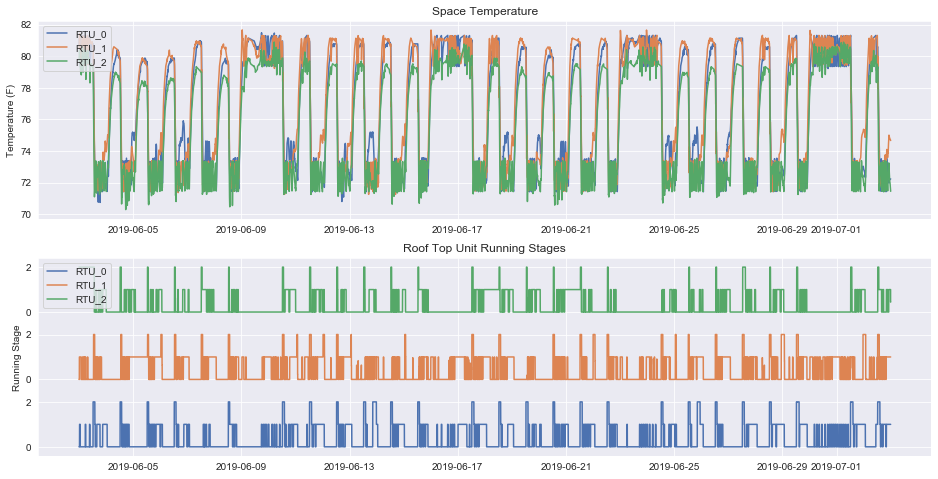

In [93]:
def plot_data(df):
    sptv = df.loc[:, df.columns.str.startswith('sptv')]
    otv = df.loc[:, df.columns == 'otv']
    u = df.loc[:, df.columns.str.startswith('u')]
    
    labels = [f'RTU_{i}' for i in range(3)]
    
    plt.figure(figsize=(16, 8))
    plt.subplot(211)
    plt.title('Space Temperature')
    plt.plot(df.index, sptv)
    plt.ylabel('Temperature (F)')
    plt.legend(labels, loc='upper left')
    plt.subplot(212)
    plt.title('Roof Top Unit Running Stages')
    plt.step(df.index, u.values.reshape(-1, 3, 2).sum(-1) + np.arange(3) * 3.0)
    plt.ylabel('Running Stage')
    plt.yticks([0, 2, 3, 5, 6, 8], [0, 2] * 3)
    plt.legend(labels, loc='upper left')
    plt.show() 

plot_data(raw_data)

In [253]:
from sklearn import preprocessing

def make_dataset(df):
    
    sptv = df.loc[:, df.columns.str.startswith('sptv')].copy()
    u = df.loc[:, df.columns.str.startswith('u')]
    dsptv = ((sptv.shift(-1) - sptv.shift()) / 2)

    sptv.iloc[:] = preprocessing.scale(sptv.values)
    idx = slice(1, -1)
    
    return TensorDataset(*[torch.tensor(vals, dtype=torch.float32) for vals in [np.hstack([sptv[idx], u[idx]]), dsptv[idx].values]])

In [255]:
class MyModel(nn.Module):
    
    def __init__(self, shape, activation_fn=torch.tanh, before_activation=True):
        super().__init__()
        
        self.layers = nn.ModuleList()
        
        for inp, out in zip(shape[:-2], shape[1:-1]):
            self.layers.append(nn.Linear(inp, out))
            self.layers.append(nn.BatchNorm1d(out))
            
        self.layers.append(nn.Linear(shape[-2], shape[-1]))
        self.activation_fn = activation_fn
        self.offset = 1 if before_activation else 0
        
    def forward(self, inp):
        x = inp
        
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            
            if (i + self.offset) % 2 == 0:
                x = self.activation_fn(x)
        
        return self.layers[-1](x)

In [257]:
dataset = make_dataset(raw_data)

In [291]:
x = [torch.tensor(x) for x in np.random.randn(10)]

print(x)

torch.stack(x)

[tensor(1.2162), tensor(-1.1191), tensor(-1.7722), tensor(0.1526), tensor(-0.4050), tensor(-0.9755), tensor(-0.2973), tensor(0.5226), tensor(-1.5863), tensor(-1.1288)]


tensor([ 1.2162, -1.1191, -1.7722,  0.1526, -0.4050, -0.9755, -0.2973,  0.5226,
        -1.5863, -1.1288])

In [295]:
from sklearn.model_selection import KFold

def train_loop(n_epoch, model, optimizer, loss_fn, dataset, batch_size=128):
    loader = DataLoader(dataset, batch_size=batch_size)
    
    with tqdm(range(n_epoch)) as prog:
        for epoch in prog:
            for inp, out in loader:
                loss = loss_fn(model(inp), out)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
    return model.eval()

def test():
    kf = KFold(n_splits=5)
    
    for before_activation in [True, False]:
        losses = []
        for train_index, valid_index in kf.split(dataset):
            model = MyModel((9, 32, 32, 3), before_activation=before_activation)
            optimizer = optim.Adam(model.parameters())
            loss_fn = nn.SmoothL1Loss()

            model = train_loop(100, model, optimizer, loss_fn, Subset(dataset, train_index))

            valid_inp, valid_out = dataset[valid_index]
            losses.append(loss_fn(model(valid_inp), valid_out).detach())

        losses = torch.stack(losses)
        print('BatchNorm -> Activation:' if before_activation else 'Activation -> BatchNorm:', losses, losses.mean(), losses.std())
    
    


test()
    

  0%|          | 0/100 [00:00<?, ?it/s]

BatchNorm -> Activation: tensor([0.0214, 0.0160, 0.0183, 0.0144, 0.0182]) tensor(0.0176) tensor(0.0026)


100%|██████████| 100/100 [00:42<00:00,  2.44it/s]

Activation -> BatchNorm: tensor([0.0214, 0.0165, 0.0193, 0.0149, 0.0232]) tensor(0.0191) tensor(0.0034)
